In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

batch_size = 64

train_dl = DataLoader(MNIST(root='./MNIST_data', train=True, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)
test_dl = DataLoader(MNIST(root='./MNIST_data', train=False, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)

torch.Size([1, 28, 28])


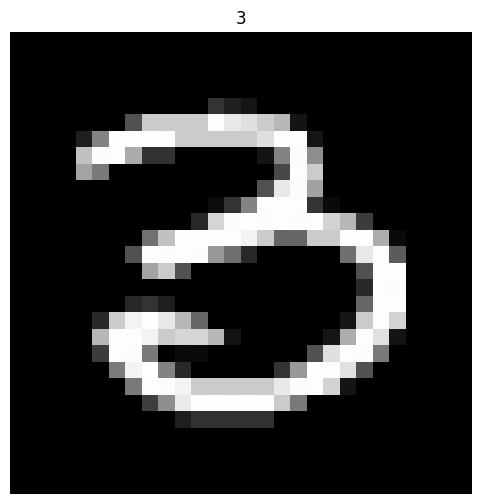

In [10]:
import matplotlib.pyplot as plt

# Get the first batch of images
images, labels = next(iter(train_dl))
image, label = images[0], labels[0]
print(image.shape)

# Reshape and convert to numpy array for plotting
image = image.squeeze().numpy()

# Create a figure and display the image
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title(f'{label}')
plt.show()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [12]:
class DiffusionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28 + 1, 1024), # +1 for the noise level
            nn.ReLU(),
            nn.Linear(1024, 2056),
            nn.ReLU(),
            nn.Linear(2056, 2056),
            nn.ReLU(),
            nn.Linear(2056, 2056),
            nn.ReLU(),
            nn.Linear(2056, 2056),
            nn.ReLU(),
            nn.Linear(2056, 28*28)
        )

    def forward(self, x, noise_level):
        x_and_t = torch.cat([x, noise_level], dim=1)
        return self.model(x_and_t)

In [13]:
model_1 = DiffusionModel().to(device)
model_2 = DiffusionModel().to(device)
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.0005)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.0005)

epochs = 10

In [14]:
losses_1 = {}
losses_2 = {}
test_losses_1 = {}
test_losses_2 = {}

for epoch in range(epochs):
    epoch_losses_1 = []
    epoch_losses_2 = []
    epoch_test_losses_1 = []
    epoch_test_losses_2 = []
    for batch in train_dl:
        x, y = batch
        batch_size = x.shape[0]
        x = x.cuda().reshape(batch_size, 28*28)

        noise_level = torch.rand(batch_size, 1, device=x.device)
        noise = torch.randn_like(x, device=x.device)
        noisy_x = x * (1 - noise_level) + noise * noise_level

        optimizer_1.zero_grad()
        optimizer_2.zero_grad()

        # x_0-prediction
        loss_1 = F.mse_loss(model_1(noisy_x, noise_level), target=x)
        loss_1.backward()
        optimizer_1.step()

        # V-prediction
        loss_2 = F.mse_loss(model_2(noisy_x, noise_level), target=(noise - x))
        loss_2.backward()
        optimizer_2.step()

        epoch_losses_1.append(loss_1.item())
        epoch_losses_2.append(loss_2.item())

        # Calculate test losses
        with torch.no_grad():
            x, y = next(iter(test_dl))
            batch_size = x.shape[0]
            x = x.cuda().reshape(batch_size, 28*28)

            noise_level = torch.rand(batch_size, 1, device=x.device)
            noise = torch.randn_like(x, device=x.device)
            noisy_x = x * (1 - noise_level) + noise * noise_level
            
            test_loss_1 = F.mse_loss(model_1(noisy_x, noise_level), target=x)
            test_loss_2 = F.mse_loss(model_2(noisy_x, noise_level), target=(noise - x))
            epoch_test_losses_1.append(test_loss_1.item())
            epoch_test_losses_2.append(test_loss_2.item())

    losses_1[epoch] = epoch_losses_1
    losses_2[epoch] = epoch_losses_2
    test_losses_1[epoch] = epoch_test_losses_1
    test_losses_2[epoch] = epoch_test_losses_2
    print(f'Epoch {epoch+1}/{epochs}, Loss 1: {loss_1.item()}, Test Loss 1: {test_loss_1.item()}, Loss 2: {loss_2.item()}, Test Loss 2: {test_loss_2.item()}')


Epoch 1/10, Loss 1: 0.04392431676387787, Test Loss 1: 0.0514448806643486, Loss 2: 1.060958981513977, Test Loss 2: 1.0542970895767212
Epoch 2/10, Loss 1: 0.048740580677986145, Test Loss 1: 0.043853338807821274, Loss 2: 1.0531554222106934, Test Loss 2: 1.0384761095046997
Epoch 3/10, Loss 1: 0.04036777839064598, Test Loss 1: 0.04464861750602722, Loss 2: 1.0504964590072632, Test Loss 2: 1.0382587909698486
Epoch 4/10, Loss 1: 0.03855568915605545, Test Loss 1: 0.036961592733860016, Loss 2: 1.0389500856399536, Test Loss 2: 1.0291414260864258
Epoch 5/10, Loss 1: 0.031161999329924583, Test Loss 1: 0.03783969581127167, Loss 2: 1.0269825458526611, Test Loss 2: 1.0327353477478027
Epoch 6/10, Loss 1: 0.033408988267183304, Test Loss 1: 0.041984930634498596, Loss 2: 1.0492868423461914, Test Loss 2: 1.0360666513442993
Epoch 7/10, Loss 1: 0.042731285095214844, Test Loss 1: 0.03498147055506706, Loss 2: 1.0369758605957031, Test Loss 2: 1.0233495235443115
Epoch 8/10, Loss 1: 0.030255233868956566, Test Los

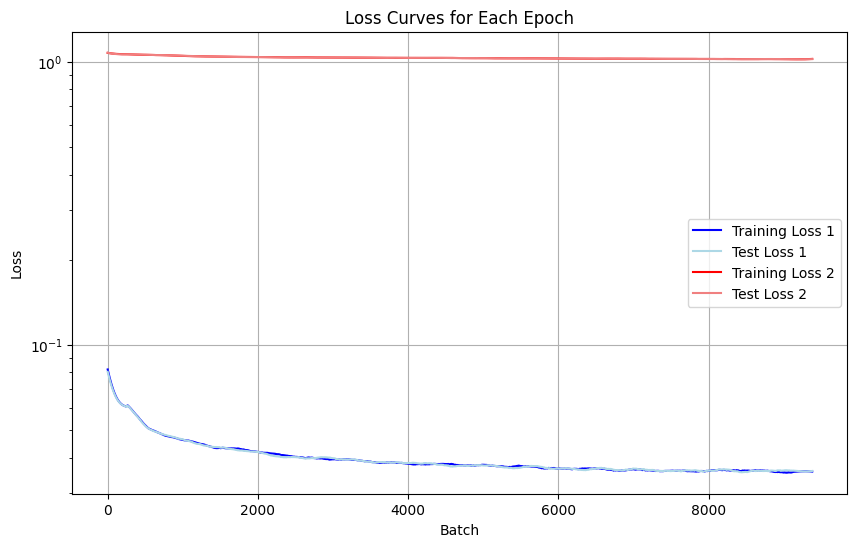

In [15]:
# Create loss curves
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

plt.figure(figsize=(10, 6))
# Append all the losses
all_losses_1 = []
all_losses_2 = []
for epoch_losses in losses_1.values():
    all_losses_1.extend(epoch_losses)
for epoch_losses in losses_2.values():
    all_losses_2.extend(epoch_losses)

all_test_losses_1 = []
all_test_losses_2 = []
for epoch_test_losses in test_losses_1.values():
    all_test_losses_1.extend(epoch_test_losses)
for epoch_test_losses in test_losses_2.values():
    all_test_losses_2.extend(epoch_test_losses)

# Savitzky-Golay filter
window_length = 501
poly_order = 3
smoothed_train_losses_1 = savgol_filter(all_losses_1, window_length, poly_order)
smoothed_test_losses_1 = savgol_filter(all_test_losses_1, window_length, poly_order)
smoothed_train_losses_2 = savgol_filter(all_losses_2, window_length, poly_order)
smoothed_test_losses_2 = savgol_filter(all_test_losses_2, window_length, poly_order)

# Plot the losses
plt.plot(smoothed_train_losses_1, label='Training Loss 1', color='blue')
plt.plot(smoothed_test_losses_1, label='Test Loss 1', color='lightblue')
plt.plot(smoothed_train_losses_2, label='Training Loss 2', color='red')
plt.plot(smoothed_test_losses_2, label='Test Loss 2', color='lightcoral')

plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss Curves for Each Epoch')
plt.legend()
plt.yscale('log')  # Using log scale for better visualization
plt.grid(True)
plt.show()


In [16]:
# Save the model
# torch.save(model.state_dict(), 'model.pt')
# print("Model saved successfully.")

In [17]:
# # Load the model
# model = DiffusionModel().to(device)
# model.load_state_dict(torch.load('model.pt'))
# model.eval()
# print("Model loaded successfully.")
# print(sum([p.numel() for p in model.parameters()]))

In [22]:
def sample_1(model, x, steps: int = 100, pred_weight: int = 4):
    pred_weight = pred_weight/steps
    x_weight = 1 - pred_weight

    for i in range(steps):
        noise_level = torch.full((x.shape[0], 1), 1 - (i + 1) / steps, device=x.device)
        pred = model.forward(x, noise_level)
        x = x * x_weight + pred * pred_weight

        x_weight = max(x_weight ** 2, 0.)
        pred_weight = 1 - x_weight

    return pred

In [25]:
def sample_2(model, x, steps: int = 100):
    for i in range(steps):
        noise_level = torch.full((x.shape[0], 1), 1 - (i + 1) / steps, device=x.device)
        predicted_v = model(x, noise_level)
        x = x - (1 / steps) * predicted_v

    return x

In [20]:
def hf_sample(model, x, steps: int = 40):
    x = x
    for i in range(steps):
        pred = model(x)
        mix_factor = 1 / (steps - i)
        x = x*(1-mix_factor) + pred*mix_factor

    return pred

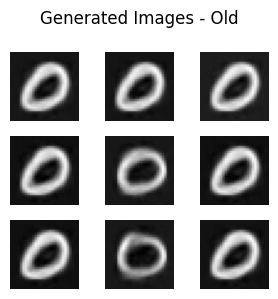

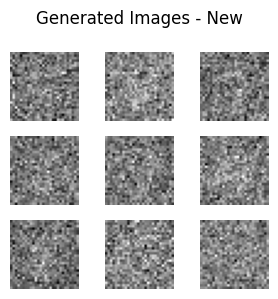

In [26]:
import matplotlib.pyplot as plt

bs = 9

x = torch.randn(bs, 28*28).to(device)

old_imgs = sample_1(model_1, x, 40, 3)
new_imgs = sample_2(model_2, x, 40)

# Plot images in a 3x3 grid for old_imgs
fig, axes = plt.subplots(3, 3, figsize=(3, 3))
fig.suptitle('Generated Images - Old')

for i, ax in enumerate(axes.flat):
    if i < len(old_imgs):
        img = old_imgs[i].reshape(28, 28).detach().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

# Plot images in a 3x3 grid for new_imgs
fig, axes = plt.subplots(3, 3, figsize=(3, 3))
fig.suptitle('Generated Images - New')

for i, ax in enumerate(axes.flat):
    if i < len(new_imgs):
        img = new_imgs[i].reshape(28, 28).detach().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()